In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance
import time

## Read two csv from john hopkin's and merge into df

In [175]:
usa = pd.read_csv("data/US_2020-05-06.csv") 
display(usa.info())
usa.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
country          72 non-null object
date             72 non-null object
confirmed        72 non-null int64
deaths           72 non-null int64
new_confirmed    72 non-null int64
new_deaths       72 non-null int64
tagged_day       72 non-null int64
dtypes: int64(5), object(2)
memory usage: 4.1+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,US,2/24/20,51,0,36,0,1
1,US,2/25/20,51,0,0,0,2
2,US,2/26/20,57,0,6,0,3
3,US,2/27/20,58,0,1,0,4
4,US,2/28/20,60,0,2,0,5


In [176]:
kor = pd.read_csv("data/SouthKorea_2020-05-06.csv") 
display(kor.info())
kor.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
country          90 non-null object
date             90 non-null object
confirmed        90 non-null int64
deaths           90 non-null int64
new_confirmed    90 non-null int64
new_deaths       90 non-null int64
tagged_day       90 non-null int64
dtypes: int64(5), object(2)
memory usage: 5.0+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,"Korea, South",2/6/20,23,0,4,0,1
1,"Korea, South",2/7/20,24,0,1,0,2
2,"Korea, South",2/8/20,24,0,0,0,3
3,"Korea, South",2/9/20,25,0,1,0,4
4,"Korea, South",2/10/20,27,0,2,0,5


In [177]:
# joining on vertical stacks (axi s0 for addition to rows) for df's of kor & usa
df = pd.concat([usa, kor], axis=0)
display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 89
Data columns (total 7 columns):
country          162 non-null object
date             162 non-null object
confirmed        162 non-null int64
deaths           162 non-null int64
new_confirmed    162 non-null int64
new_deaths       162 non-null int64
tagged_day       162 non-null int64
dtypes: int64(5), object(2)
memory usage: 10.1+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,US,2/24/20,51,0,36,0,1
1,US,2/25/20,51,0,0,0,2
2,US,2/26/20,57,0,6,0,3
3,US,2/27/20,58,0,1,0,4
4,US,2/28/20,60,0,2,0,5
...,...,...,...,...,...,...,...
85,"Korea, South",5/1/20,10780,250,6,2,86
86,"Korea, South",5/2/20,10793,250,13,0,87
87,"Korea, South",5/3/20,10801,252,8,2,88
88,"Korea, South",5/4/20,10804,254,3,2,89


In [178]:
# change date to type datetime
df['date'] = pd.to_datetime(df.date)
display(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 89
Data columns (total 7 columns):
country          162 non-null object
date             162 non-null datetime64[ns]
confirmed        162 non-null int64
deaths           162 non-null int64
new_confirmed    162 non-null int64
new_deaths       162 non-null int64
tagged_day       162 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 10.1+ KB


None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day
0,US,2020-02-24,51,0,36,0,1
1,US,2020-02-25,51,0,0,0,2
2,US,2020-02-26,57,0,6,0,3
3,US,2020-02-27,58,0,1,0,4
4,US,2020-02-28,60,0,2,0,5
...,...,...,...,...,...,...,...
85,"Korea, South",2020-05-01,10780,250,6,2,86
86,"Korea, South",2020-05-02,10793,250,13,0,87
87,"Korea, South",2020-05-03,10801,252,8,2,88
88,"Korea, South",2020-05-04,10804,254,3,2,89


#### add country code column to df

In [179]:
def country_code(row):
    if row['country'] == 'US':
        return 'USA'
    if row['country'] == 'Korea, South':
        return 'KOR'

In [180]:
df.apply(lambda row: country_code(row), axis=1)

0     USA
1     USA
2     USA
3     USA
4     USA
     ... 
85    KOR
86    KOR
87    KOR
88    KOR
89    KOR
Length: 162, dtype: object

In [181]:
df['country code'] = df.apply(lambda row: country_code(row), axis=1)
df

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code
0,US,2020-02-24,51,0,36,0,1,USA
1,US,2020-02-25,51,0,0,0,2,USA
2,US,2020-02-26,57,0,6,0,3,USA
3,US,2020-02-27,58,0,1,0,4,USA
4,US,2020-02-28,60,0,2,0,5,USA
...,...,...,...,...,...,...,...,...
85,"Korea, South",2020-05-01,10780,250,6,2,86,KOR
86,"Korea, South",2020-05-02,10793,250,13,0,87,KOR
87,"Korea, South",2020-05-03,10801,252,8,2,88,KOR
88,"Korea, South",2020-05-04,10804,254,3,2,89,KOR


## Read owa testing df

In [182]:
testing = pd.read_csv("data/covid-19-tests-deaths-scatter-with-comparisons_2020May07.csv")
display(testing.info())
testing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437 entries, 0 to 9436
Data columns (total 5 columns):
Entity                                                                            9437 non-null object
Code                                                                              8737 non-null object
Date                                                                              9437 non-null object
Total tests per million people                                                    4216 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per million)    8223 non-null float64
dtypes: float64(2), object(3)
memory usage: 368.8+ KB


None

,Entity,Code,Date,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,Afghanistan,AFG,24-Mar-20,NaN,0.026
1,Afghanistan,AFG,25-Mar-20,NaN,0.026
2,Afghanistan,AFG,26-Mar-20,NaN,0.026
3,Afghanistan,AFG,27-Mar-20,NaN,0.026
4,Afghanistan,AFG,28-Mar-20,NaN,0.051


In [183]:
# change date to type datetime
testing['Date'] = pd.to_datetime(testing.Date)
display(testing.info())
testing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437 entries, 0 to 9436
Data columns (total 5 columns):
Entity                                                                            9437 non-null object
Code                                                                              8737 non-null object
Date                                                                              9437 non-null datetime64[ns]
Total tests per million people                                                    4216 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per million)    8223 non-null float64
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 368.8+ KB


None

,Entity,Code,Date,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,Afghanistan,AFG,2020-03-24,NaN,0.026
1,Afghanistan,AFG,2020-03-25,NaN,0.026
2,Afghanistan,AFG,2020-03-26,NaN,0.026
3,Afghanistan,AFG,2020-03-27,NaN,0.026
4,Afghanistan,AFG,2020-03-28,NaN,0.051


## Joining 3 df's into one

In [184]:
# left_on = df['']

In [185]:
df2 = pd.merge(left=df, right=testing, how='left', left_on=['date','country code'], right_on=['Date', 'Code'])
display(df2.info())
df2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 161
Data columns (total 13 columns):
country                                                                           162 non-null object
date                                                                              162 non-null datetime64[ns]
confirmed                                                                         162 non-null int64
deaths                                                                            162 non-null int64
new_confirmed                                                                     162 non-null int64
new_deaths                                                                        162 non-null int64
tagged_day                                                                        162 non-null int64
country code                                                                      162 non-null object
Entity                                                                      

None

,country,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Entity,Code,Date,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,US,2020-02-24,51,0,36,0,1,USA,NaN,NaN,NaT,NaN,NaN
1,US,2020-02-25,51,0,0,0,2,USA,NaN,NaN,NaT,NaN,NaN
2,US,2020-02-26,57,0,6,0,3,USA,NaN,NaN,NaT,NaN,NaN
3,US,2020-02-27,58,0,1,0,4,USA,NaN,NaN,NaT,NaN,NaN
4,US,2020-02-28,60,0,2,0,5,USA,NaN,NaN,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,"Korea, South",2020-05-01,10780,250,6,2,86,KOR,South Korea,KOR,2020-05-01,12153.0,4.837
158,"Korea, South",2020-05-02,10793,250,13,0,87,KOR,South Korea,KOR,2020-05-02,12241.0,4.876
159,"Korea, South",2020-05-03,10801,252,8,2,88,KOR,South Korea,KOR,2020-05-03,12307.0,4.876
160,"Korea, South",2020-05-04,10804,254,3,2,89,KOR,South Korea,KOR,2020-05-04,12365.0,4.915


In [186]:
df3 = df2.copy(deep=True)

# needed cols: 'country code','date','tagged_day','Total tests per million people','confirmed','deaths','new_confirmed','new_deaths', 
#                    'Total confirmed deaths due to COVID-19 per million people (deaths per million)'

df3_dropped_cols = ['country', 'Entity', 'Code', 'Date']
df3 = df3.drop(labels=df3_dropped_cols, axis=1)
df3

,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,2020-02-24,51,0,36,0,1,USA,NaN,NaN
1,2020-02-25,51,0,0,0,2,USA,NaN,NaN
2,2020-02-26,57,0,6,0,3,USA,NaN,NaN
3,2020-02-27,58,0,1,0,4,USA,NaN,NaN
4,2020-02-28,60,0,2,0,5,USA,NaN,NaN
...,...,...,...,...,...,...,...,...,...
157,2020-05-01,10780,250,6,2,86,KOR,12153.0,4.837
158,2020-05-02,10793,250,13,0,87,KOR,12241.0,4.876
159,2020-05-03,10801,252,8,2,88,KOR,12307.0,4.876
160,2020-05-04,10804,254,3,2,89,KOR,12365.0,4.915


In [187]:
# df3.to_csv("df3.out.csv", index= False)

In [189]:
df4 = df3.copy(deep=True)
display(df4.shape)
display(df4.info())

(162, 9)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 161
Data columns (total 9 columns):
date                                                                              162 non-null datetime64[ns]
confirmed                                                                         162 non-null int64
deaths                                                                            162 non-null int64
new_confirmed                                                                     162 non-null int64
new_deaths                                                                        162 non-null int64
tagged_day                                                                        162 non-null int64
country code                                                                      162 non-null object
Total tests per million people                                                    150 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per millio

None

In [190]:
df4['Total tests per million people'] = df4['Total tests per million people'].replace(to_replace=np.NaN,value=0)
df4['Total confirmed deaths due to COVID-19 per million people (deaths per million)'] = df4['Total confirmed deaths due to COVID-19 per million people (deaths per million)'].replace(to_replace=np.NaN,value=0)
display(df4.info())
df4.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 0 to 161
Data columns (total 9 columns):
date                                                                              162 non-null datetime64[ns]
confirmed                                                                         162 non-null int64
deaths                                                                            162 non-null int64
new_confirmed                                                                     162 non-null int64
new_deaths                                                                        162 non-null int64
tagged_day                                                                        162 non-null int64
country code                                                                      162 non-null object
Total tests per million people                                                    162 non-null float64
Total confirmed deaths due to COVID-19 per million people (deaths per millio

None

,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,2020-02-24,51,0,36,0,1,USA,0.0,0.0
1,2020-02-25,51,0,0,0,2,USA,0.0,0.0
2,2020-02-26,57,0,6,0,3,USA,0.0,0.0
3,2020-02-27,58,0,1,0,4,USA,0.0,0.0
4,2020-02-28,60,0,2,0,5,USA,0.0,0.0


In [191]:
dfkor = df4.loc[df4['country code'] == 'USA']
dfkor

,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
0,2020-02-24,51,0,36,0,1,USA,0.0,0.000
1,2020-02-25,51,0,0,0,2,USA,0.0,0.000
2,2020-02-26,57,0,6,0,3,USA,0.0,0.000
3,2020-02-27,58,0,1,0,4,USA,0.0,0.000
4,2020-02-28,60,0,2,0,5,USA,0.0,0.000
...,...,...,...,...,...,...,...,...,...
67,2020-05-01,1103461,64943,34037,1947,68,USA,19794.0,190.349
68,2020-05-02,1132539,66369,29078,1426,69,USA,20559.0,196.578
69,2020-05-03,1158040,67682,25501,1313,70,USA,21309.0,200.557
70,2020-05-04,1180375,68922,22335,1240,71,USA,22010.0,204.476


In [192]:
dfusa = df4.loc[df4['country code'] == 'KOR']
dfusa

,date,confirmed,deaths,new_confirmed,new_deaths,tagged_day,country code,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
72,2020-02-06,23,0,4,0,1,KOR,17.0,0.000
73,2020-02-07,24,0,1,0,2,KOR,22.0,0.000
74,2020-02-08,24,0,0,0,3,KOR,33.0,0.000
75,2020-02-09,25,0,1,0,4,KOR,46.0,0.000
76,2020-02-10,27,0,2,0,5,KOR,54.0,0.000
...,...,...,...,...,...,...,...,...,...
157,2020-05-01,10780,250,6,2,86,KOR,12153.0,4.837
158,2020-05-02,10793,250,13,0,87,KOR,12241.0,4.876
159,2020-05-03,10801,252,8,2,88,KOR,12307.0,4.876
160,2020-05-04,10804,254,3,2,89,KOR,12365.0,4.915


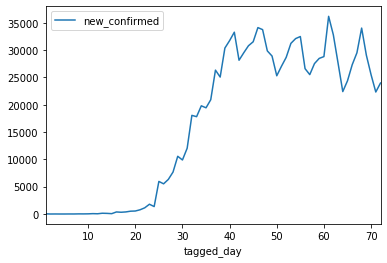

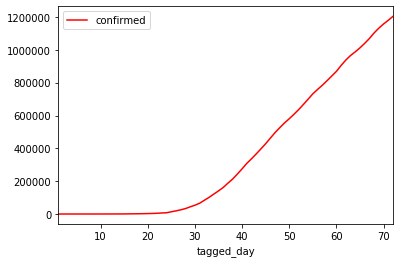

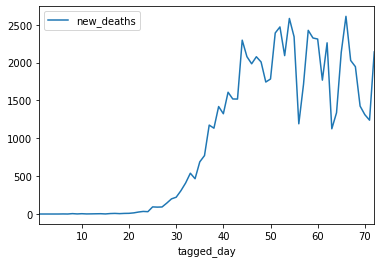

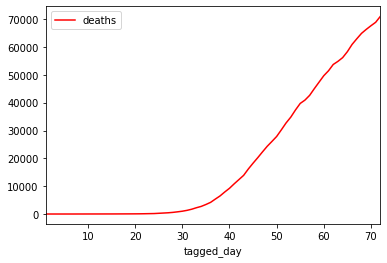

In [193]:
dfkor.plot(x='tagged_day', y='new_confirmed')
dfkor.plot(x='tagged_day', y='confirmed', color = 'red')
dfkor.plot(x='tagged_day', y='new_deaths')
dfkor.plot(x='tagged_day', y='deaths', color = 'red')

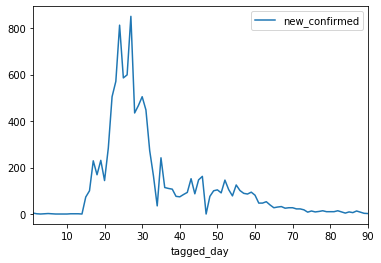

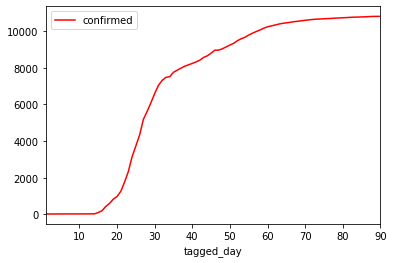

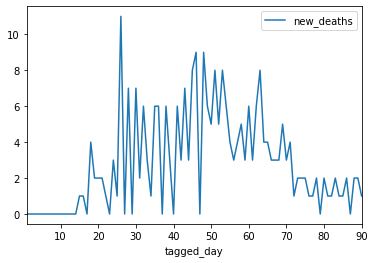

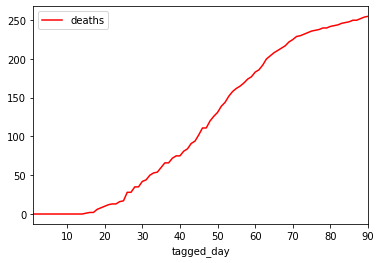

In [194]:
dfusa.plot(x='tagged_day', y='new_confirmed')
dfusa.plot(x='tagged_day', y='confirmed', color = 'red')
dfusa.plot(x='tagged_day', y='new_deaths')
dfusa.plot(x='tagged_day', y='deaths', color = 'red')

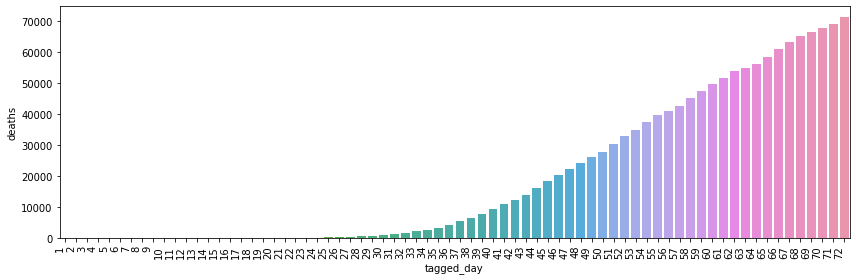

In [195]:
plt.figure(figsize=(12,4))
ax1 = sns.barplot(x="tagged_day", y="deaths", data=dfkor)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

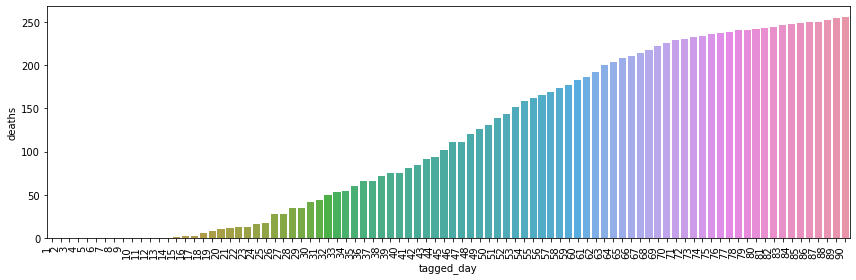

In [196]:
plt.figure(figsize=(12,4))
ax2 = sns.barplot(x="tagged_day", y="deaths", data=dfusa)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

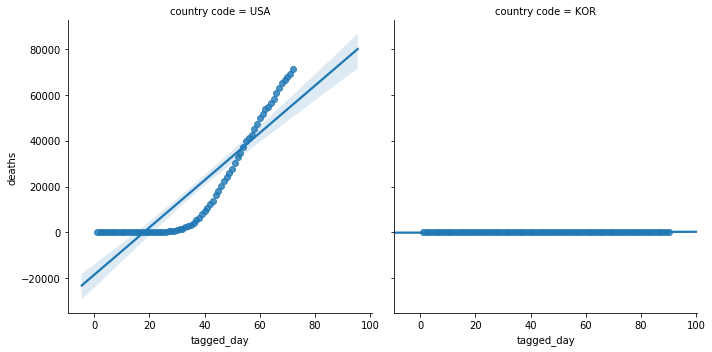

In [197]:
sns.lmplot(x="tagged_day", y="deaths", data = df4, col="country code")

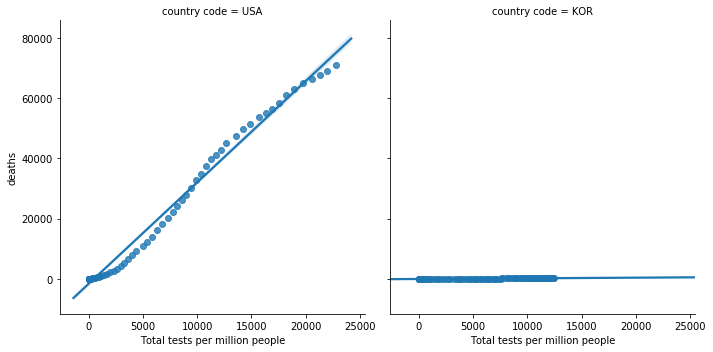

In [198]:
sns.lmplot(x="Total tests per million people", y="deaths", data = df4, col="country code")

In [199]:
display(dfkor.corr())
display(dfusa.corr())

,confirmed,deaths,new_confirmed,new_deaths,tagged_day,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
confirmed,1.000000,0.993862,0.771420,0.824617,0.938866,0.995763,0.983410
deaths,0.993862,1.000000,0.701341,0.771188,0.907931,0.994873,0.997012
new_confirmed,0.771420,0.701341,1.000000,0.921291,0.879401,0.739477,0.655452
new_deaths,0.824617,0.771188,0.921291,1.000000,0.864160,0.786446,0.724620
tagged_day,0.938866,0.907931,0.879401,0.864160,1.000000,0.929302,0.885939
Total tests per million people,0.995763,0.994873,0.739477,0.786446,0.929302,1.000000,0.988756
Total confirmed deaths due to COVID-19 per million people (deaths per million),0.983410,0.997012,0.655452,0.724620,0.885939,0.988756,1.000000


,confirmed,deaths,new_confirmed,new_deaths,tagged_day,Total tests per million people,Total confirmed deaths due to COVID-19 per million people (deaths per million)
confirmed,1.000000,0.896063,-0.214460,0.392806,0.920528,0.940372,0.896894
deaths,0.896063,1.000000,-0.411539,0.151518,0.982953,0.991286,0.999889
new_confirmed,-0.214460,-0.411539,1.000000,0.181526,-0.316819,-0.369502,-0.414068
new_deaths,0.392806,0.151518,0.181526,1.000000,0.177280,0.202687,0.148119
tagged_day,0.920528,0.982953,-0.316819,0.177280,1.000000,0.991680,0.982512
Total tests per million people,0.940372,0.991286,-0.369502,0.202687,0.991680,1.000000,0.991446
Total confirmed deaths due to COVID-19 per million people (deaths per million),0.896894,0.999889,-0.414068,0.148119,0.982512,0.991446,1.000000


# Split train & test for south korea

In [200]:
# dropping new_deaths and using deaths(cumulative) as repsonse variable
# dropping new_confirmed, since using cumulative values for confirmed cases & deaths
# dropping total confirmed deaths pe rmillion, directly correlated with deaths
# country code, since df contains all values of same country
# removing date, since tagged_day is added 
# using deaths as response variable Y
X_col_dropped = ['date','deaths','new_confirmed', 'new_deaths', 'country code',
                'Total confirmed deaths due to COVID-19 per million people (deaths per million)']
X_kor = dfkor.drop(labels=X_col_dropped, axis=1)

X_col_names = X_kor.columns.values
X_col_names

array(['confirmed', 'tagged_day', 'Total tests per million people'],
      dtype=object)

In [201]:
y_kor = dfkor.loc[:,'deaths']
y_kor.head()

0    0
1    0
2    0
3    0
4    0
Name: deaths, dtype: int64

In [202]:
X_train_kor, X_test_kor, y_train_kor, y_test_kor = train_test_split(X_kor, y_kor, test_size=0.3, random_state=1)
print(len(X_train_kor),len(y_train_kor))
print(len(X_test_kor),len(y_test_kor))

50 50
22 22


# XGB regression

In [203]:
model_kor = XGBRegressor(n_jobs=-1)
model_kor.fit(X_train_kor, y_train_kor)

[11:57:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [204]:
y_pred_kor = model_kor.predict(X_test_kor)
y_pred_kor

array([4.8659046e+01, 4.5080020e+04, 1.5108795e+01, 6.7618555e+04,
       3.4823473e+04, 3.5104080e+02, 1.2373523e+04, 3.4823473e+04,
       2.2669375e+03, 5.1487152e+04, 1.2373523e+04, 2.2669375e+03,
       7.8755999e+00, 2.6083348e+04, 5.3653169e+03, 6.4982090e+03,
       3.6387291e+01, 4.5080020e+04, 2.2669375e+03, 6.0954379e+04,
       4.5080020e+04, 6.7618555e+04], dtype=float32)

In [205]:
mse = mean_squared_error(y_test_kor,y_pred_kor)
mae = mean_absolute_error(y_test_kor,y_pred_kor)
# r2_score = r2_score(y_test_kor,y_pred_kor)
print("MSE for South Korea: %.2f" % mse)
print("MAE for South Korea: %.2f" % mae)
print("RMSE for South Korea: %.2f" % np.sqrt(mse))
# print("Coefficient of determination for South Korea: %.2f" % r2_score)

MSE for South Korea: 4111688.42
MAE for South Korea: 1548.61
RMSE for South Korea: 2027.73


### Min Max Scaling

In [206]:
min_max_scaler = MinMaxScaler()
X_train_kor_minmax = min_max_scaler.fit_transform(X_train_kor)# fit training set
X_test_kor_minmax = min_max_scaler.transform(X_test_kor)# test set transform only, no fit
X_test_kor_minmax

array([[2.22203770e-03, 2.67605634e-01, 4.16812917e-03],
       [6.30040688e-01, 7.74647887e-01, 5.15838891e-01],
       [1.37839409e-04, 1.40845070e-01, 0.00000000e+00],
       [9.40370340e-01, 9.57746479e-01, 9.02027027e-01],
       [5.80964046e-01, 7.46478873e-01, 4.74903475e-01],
       [2.12148136e-02, 3.66197183e-01, 2.72025272e-02],
       [2.28610811e-01, 5.49295775e-01, 1.91163566e-01],
       [6.07943204e-01, 7.60563380e-01, 4.93769744e-01],
       [1.00817072e-01, 4.64788732e-01, 1.01658477e-01],
       [7.21679814e-01, 8.30985915e-01, 6.22235872e-01],
       [2.56247613e-01, 5.63380282e-01, 2.21481221e-01],
       [6.95715353e-02, 4.36619718e-01, 7.41488241e-02],
       [4.98214731e-06, 2.81690141e-02, 0.00000000e+00],
       [4.82079216e-01, 6.90140845e-01, 3.94392769e-01],
       [1.34335299e-01, 4.92957746e-01, 1.28992629e-01],
       [2.02251100e-01, 5.35211268e-01, 1.73613549e-01],
       [7.53964959e-04, 2.11267606e-01, 1.18462618e-03],
       [6.51228930e-01, 7.88732

In [207]:
model_kor = XGBRegressor(n_jobs=-1)
model_kor.fit(X_train_kor_minmax, y_train_kor)

[11:57:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [208]:
y_pred_kor_minmax = model_kor.predict(X_test_kor_minmax)
y_pred_kor_minmax

array([4.8659046e+01, 4.5080020e+04, 1.5108795e+01, 6.7618555e+04,
       3.4823473e+04, 3.5104080e+02, 1.2373523e+04, 3.4823473e+04,
       2.2669375e+03, 5.1487152e+04, 1.2373523e+04, 2.2669375e+03,
       7.8755999e+00, 2.6083348e+04, 5.3653169e+03, 6.4982090e+03,
       3.6387291e+01, 4.5080020e+04, 2.2669375e+03, 6.0954379e+04,
       4.5080020e+04, 6.7618555e+04], dtype=float32)

In [209]:
mse = mean_squared_error(y_test_kor,y_pred_kor_minmax)
mae = mean_absolute_error(y_test_kor,y_pred_kor_minmax)
# r2_score = r2_score(y_test_kor,y_pred_kor_minmax)
print("MSE for South Korea: %.2f" % mse)
print("MAE for South Korea: %.2f" % mae)
print("RMSE for South Korea: %.2f" % np.sqrt(mse))
# print("Coefficient of determination for South Korea: %.2f" % r2_score)

MSE for South Korea: 4111688.42
MAE for South Korea: 1548.61
RMSE for South Korea: 2027.73


### GridSearch: param tuning for south korea

In [210]:
learning_rate_range = [0.01, 0.025,0.05, 0.1, 0.15, 0.2]
max_depth_range = [1,2,3,4,5]
subsample_range = [0.25, 0.5,1, 1.5]
n_estimators_range = [400, 600,800,1000, 1200]

param_grid = dict(learning_rate=learning_rate_range, max_depth=max_depth_range,
                  subsample=subsample_range, n_estimators=n_estimators_range)
param_grid

{'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.15, 0.2],
 'max_depth': [1, 2, 3, 4, 5],
 'subsample': [0.25, 0.5, 1, 1.5],
 'n_estimators': [400, 600, 800, 1000, 1200]}

In [211]:
start_time = time.time()
grid = GridSearchCV(XGBRegressor(n_jobs=-1), 
                    param_grid=param_grid, 
                    n_jobs=-1)
grid.fit(X_train_kor_minmax, y_train_kor)
print(grid.best_estimator_)
print("time taken for grid search = ", time.time() - start_time)

[11:57:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.025, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.25, verbosity=1)
time taken for grid search =  14.351891279220581


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [212]:
y_pred_kor_minmax = grid.best_estimator_.predict(X_test_kor_minmax)
y_pred_kor_minmax

array([6.2870884e+01, 4.0652551e+04, 1.3021828e+01, 6.6968742e+04,
       3.5588836e+04, 4.2735355e+02, 9.4699932e+03, 3.8676043e+04,
       3.6199087e+03, 4.7862699e+04, 1.1215081e+04, 1.9992395e+03,
       5.4464900e-01, 2.8996744e+04, 5.1954429e+03, 7.3902100e+03,
       3.0398708e+01, 4.3525176e+04, 4.9662192e+03, 6.2619441e+04,
       4.6302715e+04, 6.8544758e+04], dtype=float32)

In [213]:
mse = mean_squared_error(y_test_kor,y_pred_kor_minmax)
mae = mean_absolute_error(y_test_kor,y_pred_kor_minmax)
# r2_score = r2_score(y_test_kor,y_pred_kor_minmax)
print("MSE for South Korea: %.2f" % mse)
print("MAE for South Korea: %.2f" % mae)
print("RMSE for South Korea: %.2f" % np.sqrt(mse))
# print("Coefficient of determination for South Korea: %.2f" % r2_score)

MSE for South Korea: 756751.61
MAE for South Korea: 652.67
RMSE for South Korea: 869.91


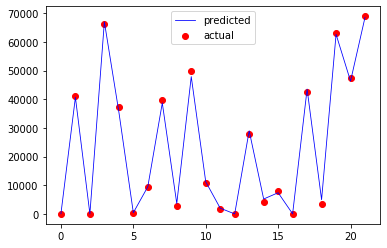

In [214]:
# actual vs predicted for South Korea
x_ax = range(len(y_test_kor))
plt.scatter(x_ax, y_test_kor, color="red", label="actual")
plt.plot(x_ax, y_pred_kor_minmax, lw=0.8, color="blue", label="predicted")
plt.legend()
plt.show()

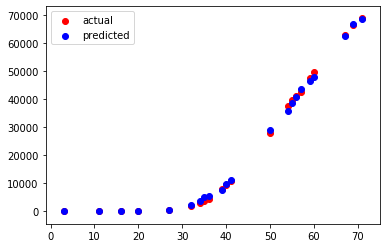

In [215]:
plt.figure()
plt.scatter(x=X_test_kor.loc[:,'tagged_day'], y=y_test_kor, color = "red", label="actual")
plt.scatter(x=X_test_kor.loc[:,'tagged_day'], y=y_pred_kor_minmax, color = "blue", label="predicted")
plt.legend()
plt.show()

# Split train & test for USA

In [216]:
# dropping new_deaths and using deaths(cumulative) as repsonse variable
# dropping new_confirmed, since using cumulative values for confirmed cases & deaths
# dropping total confirmed deaths pe rmillion, directly correlated with deaths
# country code, since df contains all values of same country
# using deaths as response variable Y
X_usa = dfusa.drop(labels=X_col_dropped, axis=1)

X_col_names2 = X_usa.columns.values
X_col_names2

array(['confirmed', 'tagged_day', 'Total tests per million people'],
      dtype=object)

In [217]:
y_usa = dfusa.loc[:,'deaths']
y_kor.head()

0    0
1    0
2    0
3    0
4    0
Name: deaths, dtype: int64

In [218]:
X_train_usa, X_test_usa, y_train_usa, y_test_usa = train_test_split(X_usa, y_usa, test_size=0.3, random_state=1)
print(len(X_train_usa),len(y_train_usa))
print(len(X_test_usa),len(y_test_usa))

63 63
27 27


## XGB regression

In [219]:
model_usa = XGBRegressor(n_jobs=-1)
model_usa.fit(X_train_usa, y_train_usa)

[11:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [220]:
y_pred_usa = model_usa.predict(X_test_usa)
y_pred_usa

array([1.8294275e+02, 2.4200294e+02, 9.0935036e+01, 1.6994531e+02,
       2.5341251e+02, 2.3696019e+02, 1.9204283e+02, 1.4414436e+02,
       1.1941342e+02, 7.2003632e+01, 8.3845055e+01, 4.4001102e+01,
       2.2979362e+02, 2.8003805e+01, 7.2003632e+01, 2.1744371e+02,
       4.1568726e-02, 4.1568726e-02, 2.5341251e+02, 2.2979362e+02,
       1.6103380e+02, 8.0109768e+00, 2.4987506e+02, 7.2003632e+01,
       5.9977287e+01, 5.9977287e+01, 1.1941342e+02], dtype=float32)

In [221]:
mse = mean_squared_error(y_test_usa,y_pred_usa)
mae = mean_absolute_error(y_test_usa,y_pred_usa)
r2_score = r2_score(y_test_usa,y_pred_usa)
print("MSE for USA: %.2f" % mse)
print("MAE for USA: %.2f" % mae)
print("RMSE for USA: %.2f" % np.sqrt(mse))
print("Coefficient of determination for USA: %.2f" % r2_score)

MSE for USA: 22.63
MAE for USA: 4.02
RMSE for USA: 4.76
Coefficient of determination for USA: 1.00


### MinMax scaling

In [222]:
min_max_scaler = MinMaxScaler()
X_train_usa_minmax = min_max_scaler.fit_transform(X_train_usa)# fit training set
X_test_usa_minmax = min_max_scaler.transform(X_test_usa)# test set transform only, no fit
X_test_usa_minmax

array([[9.39894258e-01, 6.59090909e-01, 7.17363136e-01],
       [9.92023003e-01, 8.86363636e-01, 9.29867185e-01],
       [8.00389574e-01, 4.88636364e-01, 4.98785228e-01],
       [9.14942955e-01, 6.25000000e-01, 6.64480078e-01],
       [9.99721733e-01, 9.88636364e-01, 9.95302883e-01],
       [9.87941749e-01, 8.40909091e-01, 8.87998056e-01],
       [9.51766997e-01, 6.81818182e-01, 7.35989634e-01],
       [8.86745200e-01, 5.90909091e-01, 6.21234208e-01],
       [8.29051108e-01, 5.22727273e-01, 5.32555879e-01],
       [7.61803172e-01, 4.43181818e-01, 4.32215743e-01],
       [7.69594657e-01, 4.54545455e-01, 4.51490120e-01],
       [6.76282349e-01, 3.52272727e-01, 2.96404276e-01],
       [9.80243020e-01, 7.84090909e-01, 8.42970522e-01],
       [5.19246823e-01, 3.06818182e-01, 2.14528669e-01],
       [7.54939245e-01, 4.31818182e-01, 4.22254616e-01],
       [9.77738614e-01, 7.72727273e-01, 8.31794623e-01],
       [5.56534644e-04, 1.13636364e-01, 1.10949142e-02],
       [9.27557740e-05, 2.27272

In [223]:
model_usa = XGBRegressor(n_jobs=-1)
model_usa.fit(X_train_usa_minmax, y_train_usa)

[11:57:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [224]:
y_pred_usa_minmax = model_usa.predict(X_test_usa_minmax)
y_pred_usa_minmax

array([1.8294275e+02, 2.4200294e+02, 9.0935036e+01, 1.6994531e+02,
       2.5341251e+02, 2.3696019e+02, 1.9204283e+02, 1.4414436e+02,
       1.1941342e+02, 7.2003632e+01, 8.3845055e+01, 4.4001102e+01,
       2.2979362e+02, 2.8003805e+01, 7.2003632e+01, 2.1744371e+02,
       4.1568726e-02, 4.1568726e-02, 2.5341251e+02, 2.2979362e+02,
       1.6103380e+02, 8.0109768e+00, 2.4987506e+02, 7.2003632e+01,
       5.9977287e+01, 5.9977287e+01, 1.1941342e+02], dtype=float32)

In [225]:
mse = mean_squared_error(y_test_usa,y_pred_usa_minmax)
mae = mean_absolute_error(y_test_usa,y_pred_usa_minmax)
# r2_score = r2_score(y_test_kor,y_pred_kor_minmax)
print("MSE for USA: %.2f" % mse)
print("MAE for USA: %.2f" % mae)
print("RMSE for USA: %.2f" % np.sqrt(mse))
# print("Coefficient of determination for South Korea: %.2f" % r2_score)

MSE for USA: 22.63
MAE for USA: 4.02
RMSE for USA: 4.76


### GridSearch: param tuning for USA

In [226]:
learning_rate_range = [0.01, 0.025,0.05, 0.1, 0.15, 0.2]
max_depth_range = [1,2,3,4,5]
subsample_range = [0.25, 0.5,1, 1.5]
n_estimators_range = [400, 600,800,1000, 1200]

param_grid = dict(learning_rate=learning_rate_range, max_depth=max_depth_range,
                  subsample=subsample_range, n_estimators=n_estimators_range)
param_grid

{'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.15, 0.2],
 'max_depth': [1, 2, 3, 4, 5],
 'subsample': [0.25, 0.5, 1, 1.5],
 'n_estimators': [400, 600, 800, 1000, 1200]}

In [227]:
start_time = time.time()
grid = GridSearchCV(XGBRegressor(n_jobs=-1), 
                    param_grid=param_grid, 
                    n_jobs=-1)
grid.fit(X_train_usa_minmax, y_train_usa)
print(grid.best_estimator_)
print("time taken for grid search = ", time.time() - start_time)

[11:58:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)
time taken for grid search =  13.481016159057617


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [228]:
# grid search results into selecting upper boundary values of max_ddepth & n_estimators. 
# may lead to overfitting, hence estimator values above 1200 are not added into grid search range

In [229]:
y_pred_usa_minmax = grid.best_estimator_.predict(X_test_usa_minmax)
y_pred_usa_minmax

array([1.77990860e+02, 2.41276550e+02, 9.42500763e+01, 1.68207687e+02,
       2.52499420e+02, 2.36029327e+02, 1.84754761e+02, 1.49504700e+02,
       1.14569695e+02, 7.74661865e+01, 8.06721573e+01, 4.80339317e+01,
       2.27548096e+02, 2.95650978e+01, 7.54876556e+01, 2.20401947e+02,
       2.52581239e-02, 2.52581239e-02, 2.52499420e+02, 2.30411606e+02,
       1.54563538e+02, 9.96641541e+00, 2.48976532e+02, 6.93664322e+01,
       5.74327164e+01, 5.64133530e+01, 1.14569695e+02], dtype=float32)

In [230]:
mse = mean_squared_error(y_test_usa,y_pred_usa_minmax)
mae = mean_absolute_error(y_test_usa,y_pred_usa_minmax)
print("MSE for USA: %.2f" % mse)
print("MAE for USA: %.2f" % mae)
print("RMSE for USA: %.2f" % np.sqrt(mse))
# r2_score = r2_score(y_test_kor,y_pred_kor_minmax)
# print("Coefficient of determination for South Korea: %.2f" % r2_score)

MSE for USA: 5.60
MAE for USA: 1.87
RMSE for USA: 2.37


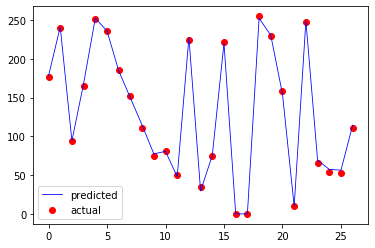

In [231]:
# actual vs predicted for USA
x_ax = range(len(y_test_usa))
plt.scatter(x_ax, y_test_usa, color="red", label="actual")
plt.plot(x_ax, y_pred_usa_minmax, lw=0.8, color="blue", label="predicted")
plt.legend()
plt.show()

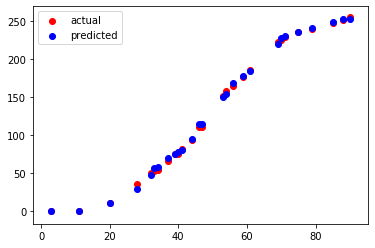

In [232]:
plt.figure()
plt.scatter(x=X_test_usa.loc[:,'tagged_day'], y=y_test_usa, color = "red", label="actual")
plt.scatter(x=X_test_usa.loc[:,'tagged_day'], y=y_pred_usa_minmax, color = "blue", label="predicted")
plt.legend()
plt.show()